'''
This file reads the heatmap data from the npy file produced by 'read_heatmap_from_txts.ipynb'.
It detects the differences in activations between different classes.
It also visualizes which class invoke which filter most.
'''

In [1]:
import os.path
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define th CLASSES and indices
CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')
class_to_ind = dict(list(zip(CLASSES, list(range(len(CLASSES))))))
SUB_CLAS = ('bicycle', 'bus', 'car','motorbike', 'person')

In [3]:
def list_normalizer(ori_list):
    '''
    normalize every element in the input list to the range of 0-1
    '''
    max_val = ori_list.max()
    min_val = ori_list.min()
    if max_val == 0:
        return ori_list
    normalized_list = [(i-min_val)/(max_val-min_val) for i in ori_list]
    return normalized_list

def display_all_act(norm_hm_one_layer):
    bins = np.linspace(-10,10,50)
    for clas in CLASSES[1:]:
        ind = class_to_ind[clas]
        _,_,_ = plt.hist(norm_hm_one_layer[ind],50,alpha=0.5,label=clas)
    plt.legend(loc='upper right')
    plt.show()

def detect_diff_one_layer(norm_hm_one_layer,RANKING=True,DISPLAY_ALL=False,DISPLAY_DIFF=False):
    '''
    detect the difference in activations for two sets within one layer
    '''
    interest_average = np.zeros((norm_hm_one_layer.shape[1],))
    uninterest_average = np.zeros((norm_hm_one_layer.shape[1],))
    diff_ind = np.zeros((norm_hm_one_layer.shape[1],))
    amplifier = 1
    
    for clas in CLASSES:
        ind = class_to_ind[clas]
        if clas in SUB_CLAS:
            interest_average[:] += norm_hm_one_layer[ind]
        else:
            uninterest_average[:] += norm_hm_one_layer[ind]
    interest_average = interest_average/len(SUB_CLAS)
    uninterest_average = uninterest_average/15.
    
    if DISPLAY_ALL:
        # display all activations for different sets
        bins = np.linspace(-10, 10, 50)
        _,_,_ = plt.hist(uninterest_average,100,alpha=0.5, label='not interest')
        _,_,_ = plt.hist(interest_average,100,alpha=0.5, label='interest')
        plt.legend(loc='upper right')
        plt.show()
    
    if DISPLAY_DIFF:
        # dsplay activation differences between two sets
        diff_ind = (interest_average - uninterest_average)*amplifier
        _,_,_ = plt.hist(diff_ind,50,alpha=0.5)
        plt.show()
    
    if RANKING:
        diff_ind = np.argsort(diff_ind)[::-1]
    return diff_ind

def detect_diff_all(hm_path,RANKING=True,DISPLAY_ALL=False,DISPLAY_DIFF=False,DISPLAY_EVERY_CLASS=False):
    '''
    detect the activations difference in different layers
    '''
    hm_all = np.load(hm_path).item()
    norm_hm_all = {}
    hm_ind = {} # dictionary to record the diff_ind for every layer
    sub_clas_index = [class_to_ind[i] for i in SUB_CLAS]
#     for key in hm_all: # for evey layer
    for i in range(13):
        key = '%dth_layer'%(i)
        norm_hm_all[key] = np.zeros(hm_all[key].shape,np.float32)
        for i,sub_list in enumerate(hm_all[key]): # for every row in the layer
            norm_hm_all[key][i,:] = sub_list
        hm_ind[key] = detect_diff_one_layer(norm_hm_all[key],RANKING,DISPLAY_ALL,DISPLAY_DIFF) # [21, 64/...]
        if DISPLAY_EVERY_CLASS:
            display_all_act(norm_hm_all[key])
        print 'this is %s layer'%key
    return hm_ind

In [4]:
# plot activation-magnitute versus filter number
def detect_diff_all_2(hm_path,RANKING=True,DISPLAY_ALL=False,DISPLAY_DIFF=False,DISPLAY_EVERY_CLASS=False):
    '''
    detect the activations difference in different layers
    '''
    hm_all = np.load(hm_path).item()
    norm_hm_all = {}
    hm_ind = {} # dictionary to record the diff_ind for every layer
    sub_clas_index = [class_to_ind[i] for i in SUB_CLAS]
#     for key in hm_all: # for evey layer
    for i in range(13):
        key = '%dth_layer'%(i)
        norm_hm_all[key] = np.zeros(hm_all[key].shape,np.float32)
        for i,sub_list in enumerate(hm_all[key]): # for every row in the layer
            norm_hm_all[key][i,:] = sub_list
        hm_ind[key] = display_each_feature_map_one_layer(norm_hm_all[key])
        print 'this is %s layer'%key
    return hm_ind

def display_each_feature_map_one_layer(norm_hm_one_layer):
    num_filter = norm_hm_one_layer.shape[1]
    uninteresting_values = np.zeros((num_filter),np.float32)
    interesting_values = np.zeros((num_filter),np.float32)
    for clas in CLASSES:
        ind = class_to_ind[clas]
        if clas in SUB_CLAS:
            interesting_values += norm_hm_one_layer[ind]
        else:
            uninteresting_values += norm_hm_one_layer[ind]
    interesting_values = interesting_values/len(SUB_CLAS)
    uninteresting_values = uninteresting_values/len(CLASSES)
    
    plt.figure()
    plt.plot(np.arange(num_filter),interesting_values,color='b')
    plt.plot(np.arange(num_filter),uninteresting_values,color='r')
    plt.show()


In [5]:
from scipy.stats import entropy
# plot activation-magnitute versus filter number
def detect_diff_all_divergence(hm_path):
    '''
    detect the activations difference in different layers
    '''
    hm_all = np.load(hm_path).item()
    norm_hm_all = {}
    hm_ind = {} # dictionary to record the diff_ind for every layer
    sub_clas_index = [class_to_ind[i] for i in SUB_CLAS]
#     for key in hm_all: # for evey layer
    for i in range(13):
        key = '%dth_layer'%(i)
        norm_hm_all[key] = np.zeros(hm_all[key].shape,np.float32)
        for i,sub_list in enumerate(hm_all[key]): # for every row in the layer
            norm_hm_all[key][i,:] = sub_list
        hm_ind[key] = KL_divergence(norm_hm_all[key])
    return hm_ind

entropies_interesting2un = []
def KL_divergence(norm_hm_one_layer):
    num_filter = norm_hm_one_layer.shape[1]
    uninteresting_values = np.zeros((num_filter),np.float32)
    interesting_values = np.zeros((num_filter),np.float32)
    for clas in CLASSES:
        ind = class_to_ind[clas]
        if clas in SUB_CLAS:
            interesting_values += norm_hm_one_layer[ind]
        else:
            uninteresting_values += norm_hm_one_layer[ind]
    interesting_values = interesting_values/len(SUB_CLAS)
    uninteresting_values = uninteresting_values/len(CLASSES)
    
    n_interesting, _, _ = plt.hist(interesting_values,bins = 50)
    n_uninteresting, _, _ = plt.hist(uninteresting_values, bins = 50)
    
    n_interesting = n_interesting/num_filter
    n_uninteresting = n_uninteresting/num_filter
    
    entropies_interesting2un.append(entropy(n_interesting, n_uninteresting))

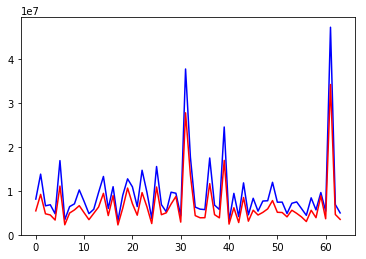

this is 0th_layer layer


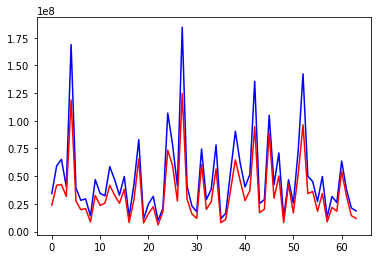

this is 1th_layer layer


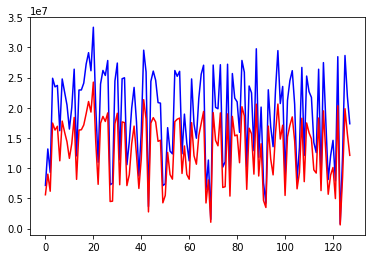

this is 2th_layer layer


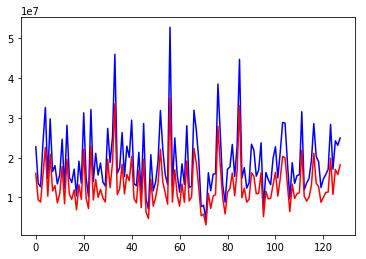

this is 3th_layer layer


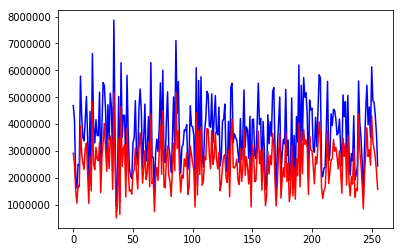

this is 4th_layer layer


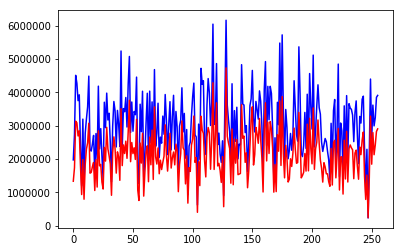

this is 5th_layer layer


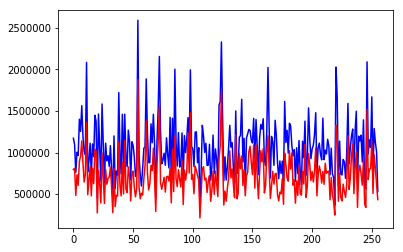

this is 6th_layer layer


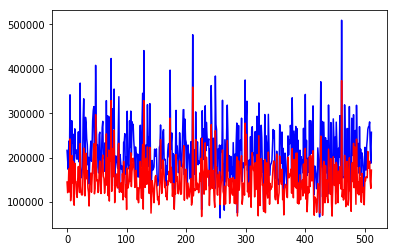

this is 7th_layer layer


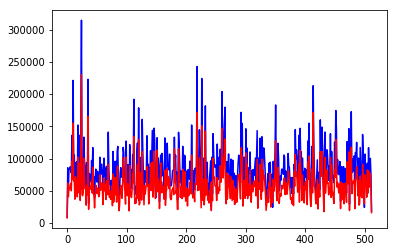

this is 8th_layer layer


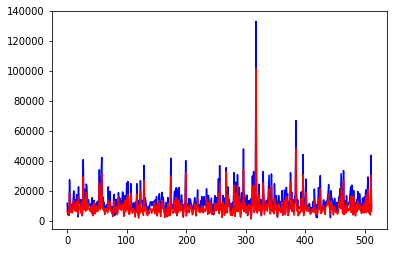

this is 9th_layer layer


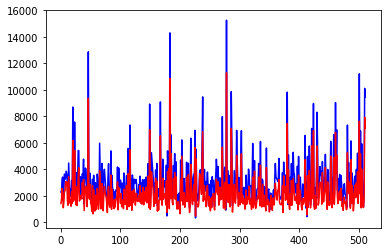

this is 10th_layer layer


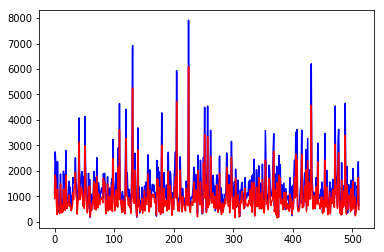

this is 11th_layer layer


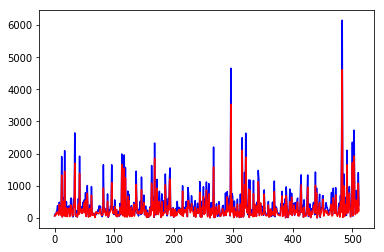

this is 12th_layer layer


In [6]:
# inspect the activations for two sets of classes
hm_path = 'activations_res/original.npy'
hm_sorted = detect_diff_all_2(hm_path,RANKING=False,DISPLAY_ALL=True)

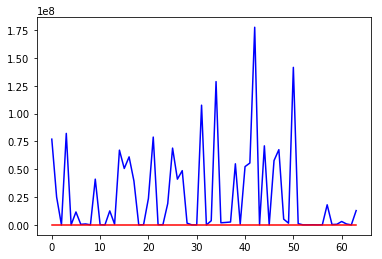

this is 0th_layer layer


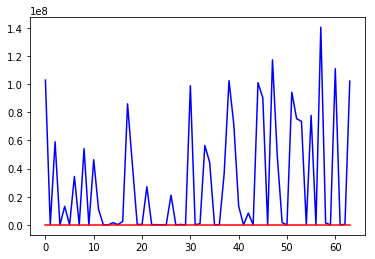

this is 1th_layer layer


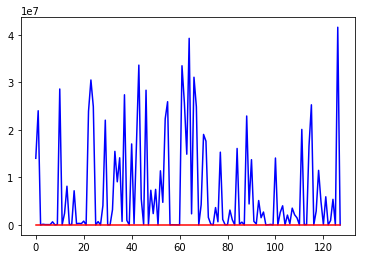

this is 2th_layer layer


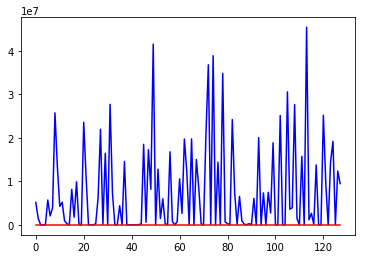

this is 3th_layer layer


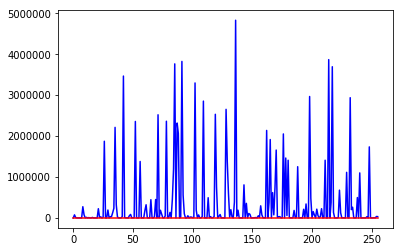

this is 4th_layer layer


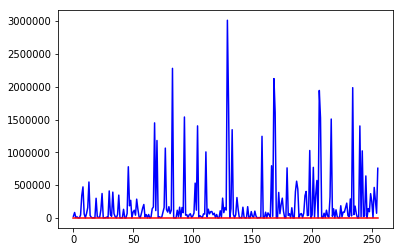

this is 5th_layer layer


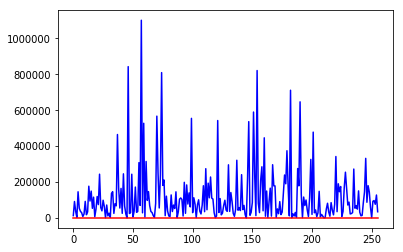

this is 6th_layer layer


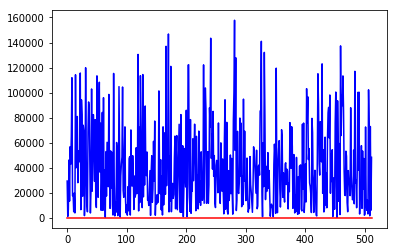

this is 7th_layer layer


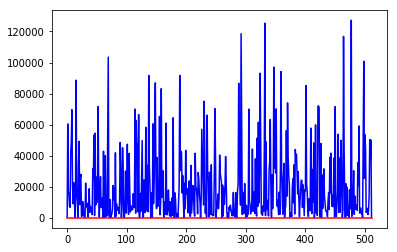

this is 8th_layer layer


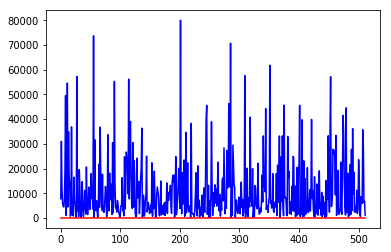

this is 9th_layer layer


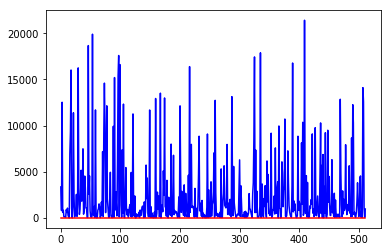

this is 10th_layer layer


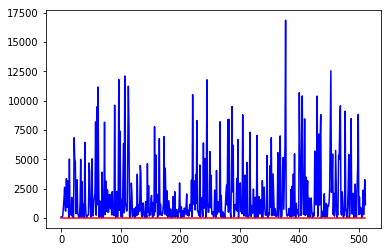

this is 11th_layer layer


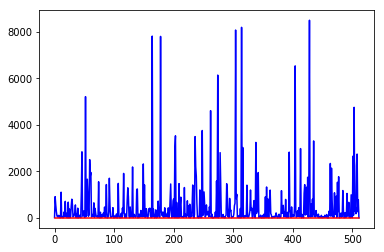

this is 12th_layer layer


In [7]:
# inspect the activations for two sets of classes
hm_path = 'activations_res/penalty0.01_iter200000.npy'
hm_sorted = detect_diff_all_2(hm_path,RANKING=False,DISPLAY_ALL=True)

[inf, inf, inf, inf, 0.14527046216429296, inf, inf, inf, inf, inf, inf, inf, inf]


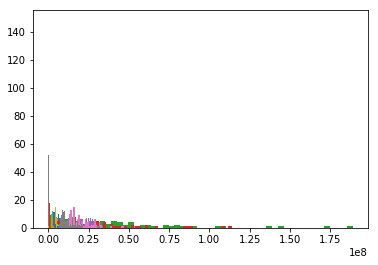

In [7]:
hm_path = 'activations_res/original_image_res.npy'
detect_diff_all_divergence(hm_path)
print(entropies_interesting2un)

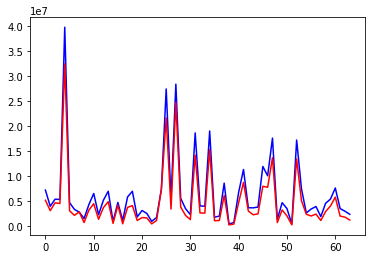

this is 0th_layer layer


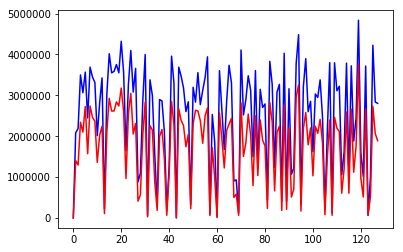

this is 1th_layer layer


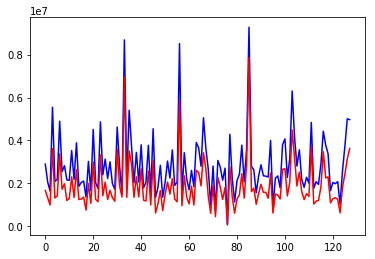

this is 2th_layer layer


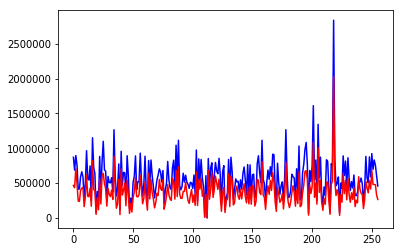

this is 3th_layer layer


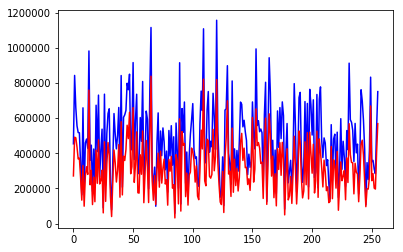

this is 4th_layer layer


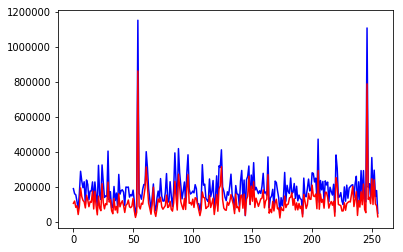

this is 5th_layer layer


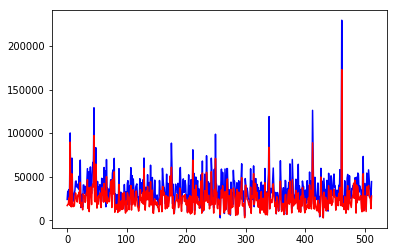

this is 6th_layer layer


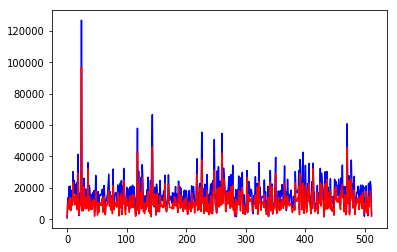

this is 7th_layer layer


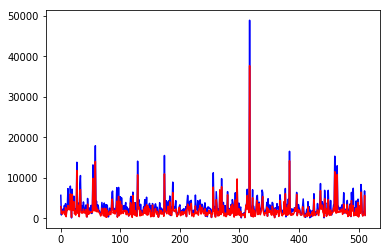

this is 8th_layer layer


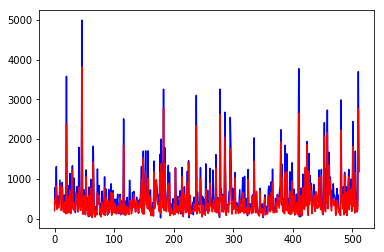

this is 9th_layer layer


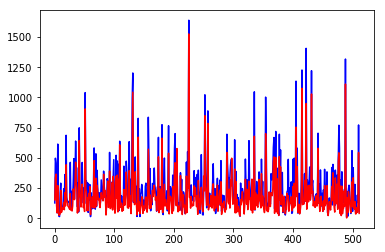

this is 10th_layer layer


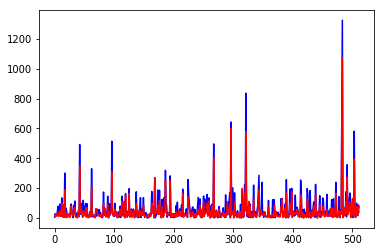

this is 11th_layer layer


KeyError: '12th_layer'

In [26]:
# inspect the activations for two sets of classes
hm_path = 'activations_res/classification-based_res.npy'
hm_sorted = detect_diff_all_2(hm_path,RANKING=False,DISPLAY_ALL=True)

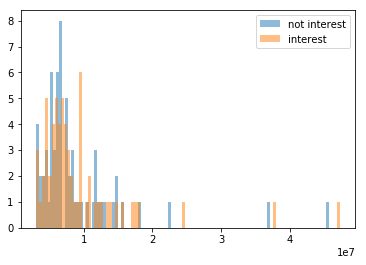

this is 0th_layer layer


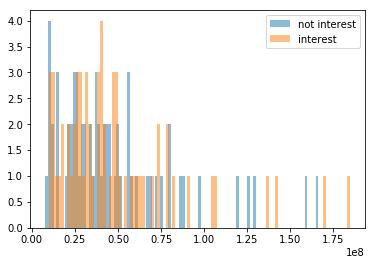

this is 1th_layer layer


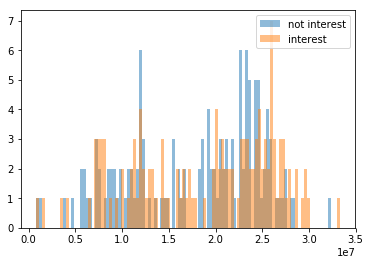

this is 2th_layer layer


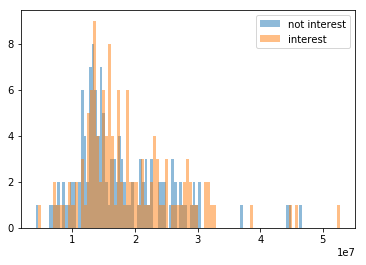

this is 3th_layer layer


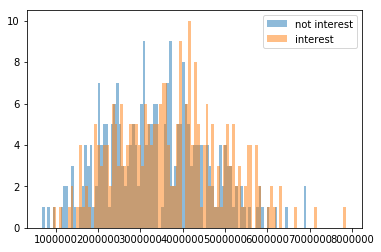

this is 4th_layer layer


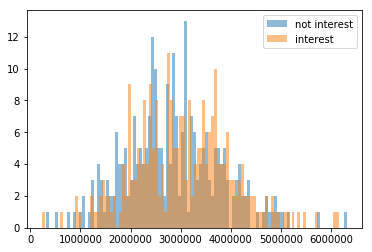

this is 5th_layer layer


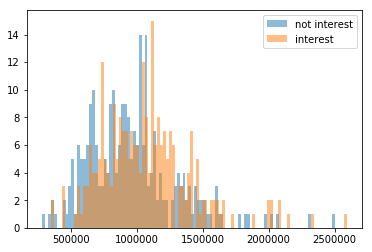

this is 6th_layer layer


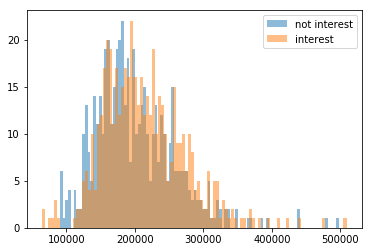

this is 7th_layer layer


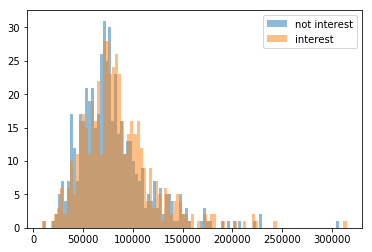

this is 8th_layer layer


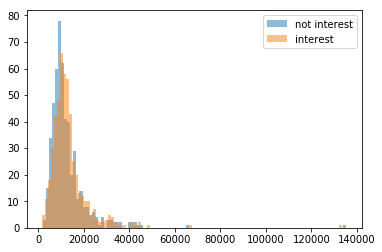

this is 9th_layer layer


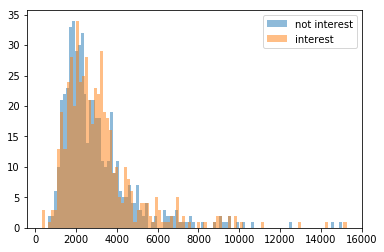

this is 10th_layer layer


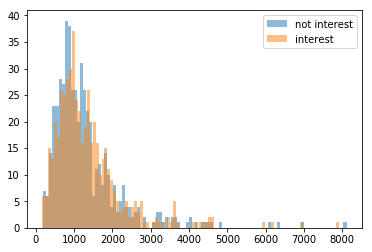

this is 11th_layer layer


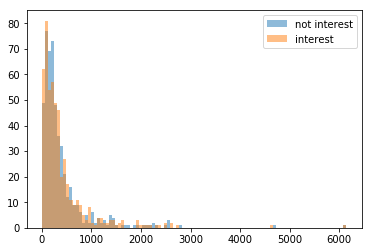

this is 12th_layer layer


In [8]:
# inspect the activations for two sets of classes
hm_path = 'activations_res/original.npy'
hm_sorted = detect_diff_all(hm_path,RANKING=False,DISPLAY_ALL=True)

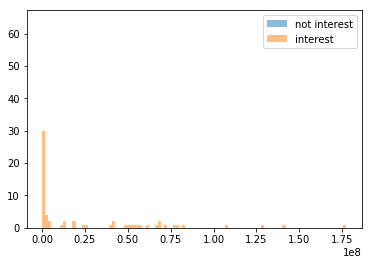

this is 0th_layer layer


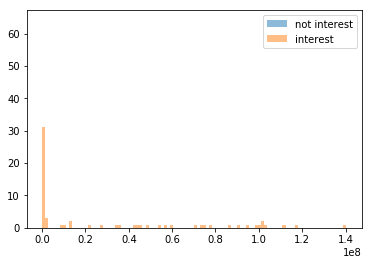

this is 1th_layer layer


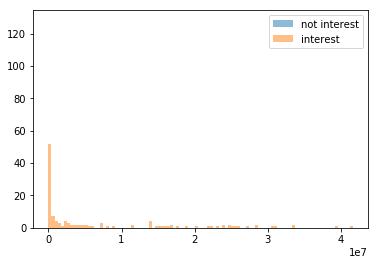

this is 2th_layer layer


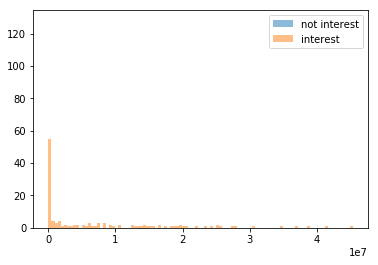

this is 3th_layer layer


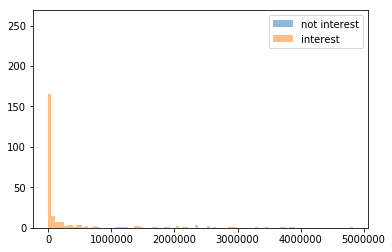

this is 4th_layer layer


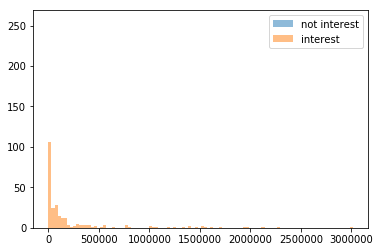

this is 5th_layer layer


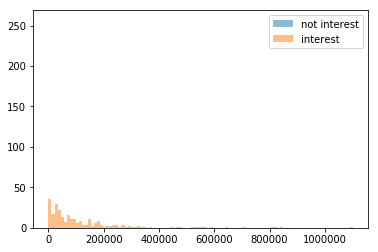

this is 6th_layer layer


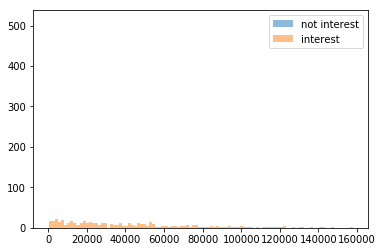

this is 7th_layer layer


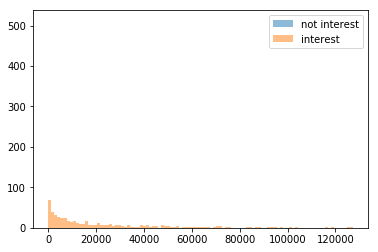

this is 8th_layer layer


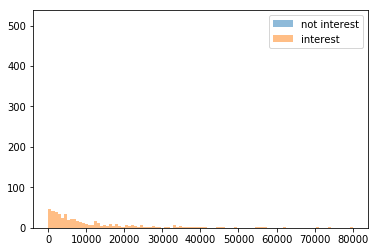

this is 9th_layer layer


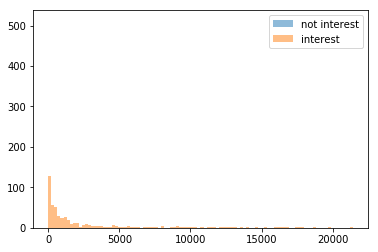

this is 10th_layer layer


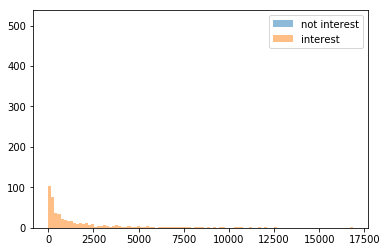

this is 11th_layer layer


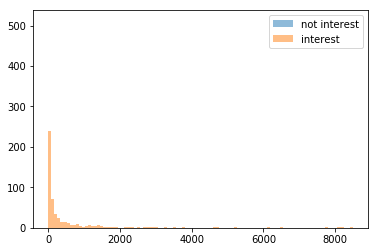

this is 12th_layer layer


In [9]:
# inspect the activations for two sets of classes
hm_path = './activations_res/penalty0.01_iter200000.npy'
hm_sorted = detect_diff_all(hm_path,RANKING=False,DISPLAY_ALL=True)

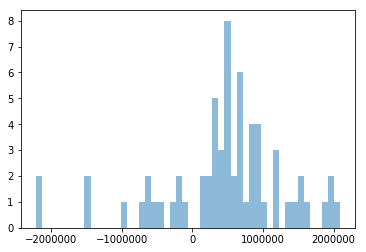

this is 0th_layer layer


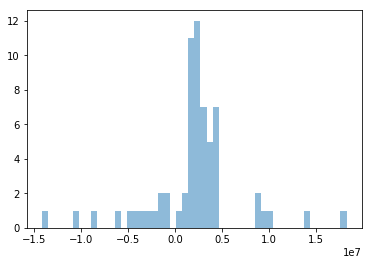

this is 1th_layer layer


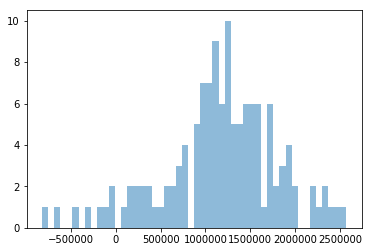

this is 2th_layer layer


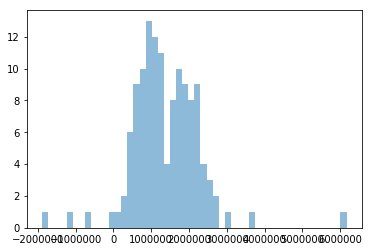

this is 3th_layer layer


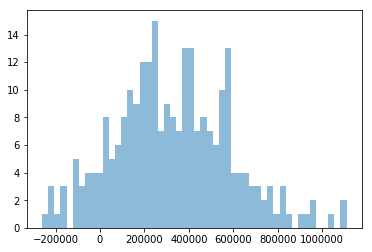

this is 4th_layer layer


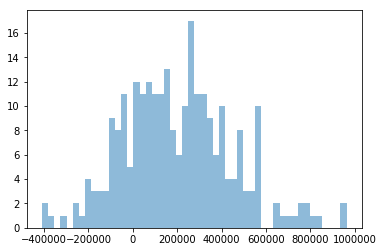

this is 5th_layer layer


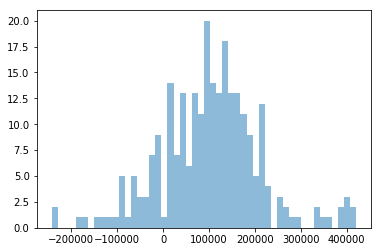

this is 6th_layer layer


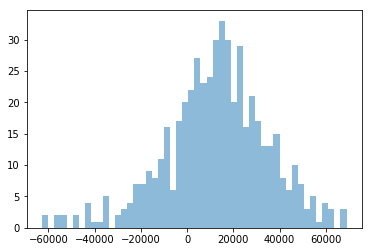

this is 7th_layer layer


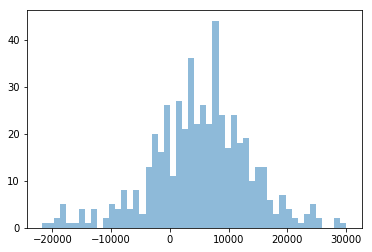

this is 8th_layer layer


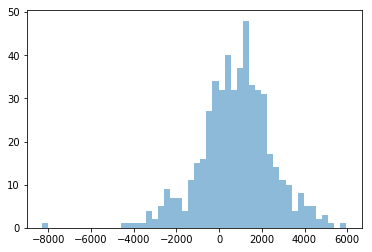

this is 9th_layer layer


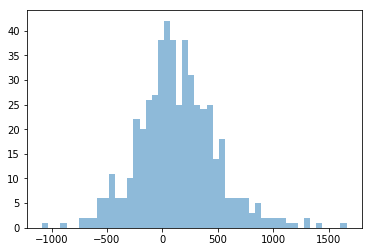

this is 10th_layer layer


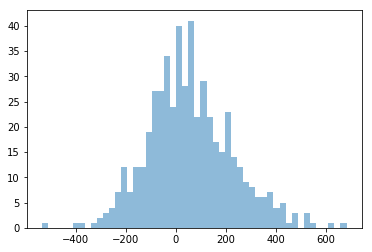

this is 11th_layer layer


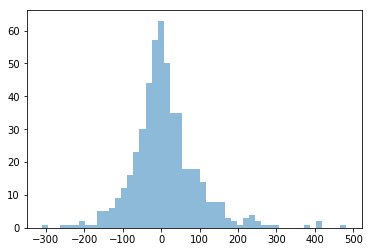

this is 12th_layer layer


In [31]:
# inspect the difference between two sets of classes
hm_path = './activations_res/original.npy'
hm_sorted = detect_diff_all(hm_path,False,False,True)

In [77]:
# inspect the difference between two sets of classes
hm_path = './activations_res/res.npy'
hm_sorted = detect_diff_all(hm_path,False)
print hm_sorted['1th_acts'].shape

(64,)


In [38]:
for key in hm_sorted:
    print key,hm_sorted[key].shape

2th_acts (64,)
9th_acts (512,)
3th_acts (128,)
6th_acts (256,)
8th_acts (512,)
7th_acts (256,)
12th_acts (512,)
10th_acts (512,)
5th_acts (256,)
13th_acts (512,)
11th_acts (512,)
4th_acts (128,)
1th_acts (64,)


In [39]:
for i in range(1,2):
    diffs = hm_sorted['%dth_acts'%i]
    print diffs.min(), diffs.max()

-0.0249834057121 0.0521205527087


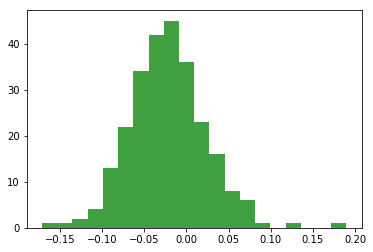

In [46]:
data = hm_sorted['5th_acts']
_,_,_ = plt.hist(data,20,facecolor='green',alpha=0.75)